In [62]:
import numpy as np
from IPython.display import clear_output, display
import torch
import random
import copy
import time
import os #to get current working directory
import csv
import matplotlib.pyplot as plt
import pickle #for storing data

from wurm.envs import SingleSnake
from wurm.envs import SimpleGridworld
from gym.wrappers.monitoring.video_recorder import VideoRecorder

DEFAULT_DEVICE = 'cuda' #set device

## Visualizing the neural network. Requires Tensorboard

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(qnet, torch.Tensor(env.reset()))
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

In [63]:
import collections

class ReplayBuffer():
    def __init__(self, max_buffer_size: int):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer = collections.deque(maxlen=max_buffer_size)

    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
    def clear_buffer(self):
        self.buffer.clear()
        
    #Sample superbatches and sub sample parallel environments
    def sample_subbatch(self,superbatch_length, subbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        sub_length = self.buffer[0][0].shape[0]
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            rand_int_1 = np.random.randint(0, sub_length, subbatch_length)
            transition = self.buffer[rand_int]
            states.append(transition[0][rand_int_1])
            next_states.append(transition[1][rand_int_1])
            actions.append(transition[2][rand_int_1])
            rewards.append(transition[3][rand_int_1])
            terminals.append(transition[4][rand_int_1])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)

    def sample_superbatch(self,superbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            transition = self.buffer[rand_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)
    
    #sample parallel environments of subbatch_length from a randomly selected buffer location.
    def sample(self, subbatch_length):
            rand_int = np.random.randint(0, len(self.buffer))
            rand_int_1 = np.random.randint(0, len(self.buffer[0][0]), subbatch_length)
            transition = self.buffer[rand_int]
            states=transition[0][rand_int_1]
            next_states=transition[1][rand_int_1]
            actions=transition[2][rand_int_1]
            rewards=transition[3][rand_int_1]
            terminals=transition[4][rand_int_1]
            return (states,next_states,actions,rewards,terminals)


In [64]:
class A2C():
    def __init__(self, NN: object, NN_args: tuple = (), 
                 num_envs: int = 1, lr: float = 0.0005, discount: float = 0.8):

        self.model = NN(*NN_args).to(DEFAULT_DEVICE)
        self.model_optim = torch.optim.Adam(self.model.parameters(), lr=lr) #set learning rate
        self.gamma = torch.Tensor([discount]).to(DEFAULT_DEVICE) # set discount factor
        
        self.lr = lr
        
    def load(self, path, device=DEFAULT_DEVICE):
        self.model = torch.load(path, map_location=device)
        self.model_optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self):
        self.model.train()
        torch.set_grad_enabled(True)
        
    def evaluate(self):
        self.model.eval()
        torch.set_grad_enabled(False)
        
    def action(self, state):
        #self.values and self.log_probs will be needed to update model in self.update()
        action_probs, self.values = self.model(state)
        dist = torch.distributions.Categorical(probs = action_probs) #defining a distribution to sample from
        actions = dist.sample() #sampling an action from the distribution
        self.log_probs = dist.log_prob(actions)
        return actions

    def update(self, next_states, rewards, terminals):
        _, next_state_values = self.model(next_states)
        
        returns = (rewards + (~terminals)*self.gamma*next_state_values).detach()
        values = self.values
        
        value_loss = torch.nn.MSELoss()(returns,values)
        advantages = returns-values
        policy_loss = -(advantages.detach()*self.log_probs).mean()
        loss = policy_loss + value_loss 
        
        self.model_optim.zero_grad()
        loss.backward()
        self.model_optim.step()

## Defining Some Neural Networks

In [88]:
class NewNet(torch.nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.layer_length = size*size
        self.common_layer = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            )
        
        self.policy_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 2, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.Linear(2*self.layer_length,4),
            torch.nn.Softmax(dim=-1)
            )
        
        self.value_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.ReLU(),
            torch.nn.Linear(self.layer_length,64),
            torch.nn.Linear(64,1)
            )
        
    def forward(self,x):
        x = self.common_layer(x)
        self.policy = self.policy_layer(x)
        self.value = self.value_layer(x)
        return (self.policy, self.value.squeeze(-1))

class SnakeNet(torch.nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.layer_length = size*size
        self.common_layer = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            )
        
        self.policy_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 2, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.Linear(2*self.layer_length,4),
            torch.nn.Softmax(dim=-1)
            )
        
        self.value_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.ReLU(),
            torch.nn.Linear(self.layer_length,64),
            torch.nn.Linear(64,1)
            )
        
    def forward(self,x):
        x = self.common_layer(x)
        self.policy = self.policy_layer(x)
        self.value = self.value_layer(x)
        return (self.policy, self.value.squeeze(-1))
        

## Initializing Environment and Agent

In [90]:
environment = 'SimpleGridworld'
num_envs = 1300 #Number of parallel environments to simulate. Use small value for cpu (eg. 1)
test_num_envs = 100 #Number of parallel environments when validating
discount = 0.8
lr = 0.0005
env_size = 10

if environment == 'SimpleGridworld':
    env = SimpleGridworld(num_envs=num_envs, size=env_size, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=True)
    test_env = SimpleGridworld(num_envs=test_num_envs, size=env_size, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    agent=A2C(NN = NewNet, NN_args = (env_size,), lr = lr, discount = discount)

elif environment == 'SingleSnake':
    env = SingleSnake(num_envs=num_envs, size=env_size, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset= True)
    test_env = SingleSnake(num_envs=test_num_envs, size=env_size, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    agent=A2C(NN = SnakeNet, NN_args = (env_size,), lr = lr, discount = discount)

else:
    raise Exception("Invalid option")

agent.train()
print(agent.model)

NewNet(
  (common_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (policy_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): Linear(in_features=200, out_features=4, bias=True)
    (4): Softmax(dim=-1)
  )
  (value_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Training

Step: 20800
Episode Completed: 24 / 100
Mean, Median, Max, Min, std: 0.1 0.0 1.0 0.0 0.3


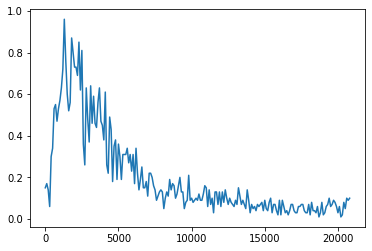

In [ ]:
#%%time
number_of_steps = 100000

####Code to compute total reward####
total_reward = torch.zeros(num_envs).to(DEFAULT_DEVICE)
step_list=[]
data_list=[]
fc_list=[] #food collected
best_fc = 0

#########Let's start Training###########################
agent.train()
state=env.reset()
for i in range(0,number_of_steps):
    ##############Learning#############################
    action = agent.action(state) 
    next_state, reward, terminal, _ = env.step(action)
    agent.update(next_state, reward, terminal)  
    state = next_state

    #############Validation############################
    if i%100 == 0:
        agent.evaluate()                        
        t_state = test_env.reset()
        fc_sum = torch.zeros((test_num_envs,)).float().to(DEFAULT_DEVICE) #foot collected
        #hit_terminal = torch.zeros((test_num_envs,)).bool().to(DEFAULT_DEVICE)
        for _ in range(1000): #max steps
            t_action = agent.action(t_state)
            t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
            #anything with a positive reward is considered as food.
            fc_sum+=(t_reward>0).float()
            #hit_terminal |= t_terminal
            t_state = t_next_state
            if t_terminal.all():
                break

        t_sum = fc_sum.cpu().numpy()
        t_mean = np.mean(t_sum)
        t_median = np.median(t_sum)
        t_max = np.max(t_sum)
        t_min = np.min(t_sum)
        t_std = np.std(t_sum)
        t_completed = t_terminal.sum().cpu().numpy()
        print('Step:', i)
        print("Episode Completed:", t_completed, "/", test_num_envs)
        print("Mean, Median, Max, Min, std:", 
              t_mean, 
              t_median,
              t_max,
              t_min,
              t_std)
        fc_list.append(t_mean)
        data_list.append((i, t_mean, t_median, t_min, t_max, t_std, t_sum))
        step_list.append(i)
        plt.plot(step_list, fc_list)
        plt.show()
        agent.train()
        if t_mean>best_fc:
            best_fc = t_mean
            torch.save(agent.model,"current_best.h5")
        clear_output(wait=True)



## Storing Data of best model and associated runtime data.

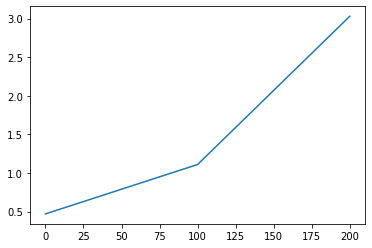

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SnakeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [58]:
#Visualizing reward
plt.plot(step_list, fc_list)
plt.show()

#file name without extension
file_name = "test3"

parameters = {"environment": environment,
              "env_size": env_size,
              "num_envs": num_envs, 
              "discount": discount, 
              "lr": lr,
              "device": DEFAULT_DEVICE
             }
heading = ["step", "mean", "median", "min", "max", "std", "raw data"]

#create folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

with open(F"data/{file_name}.csv", 'xt') as file:
    writer = csv.writer(file, lineterminator="\n")
    writer.writerow(["parameters:"])
    writer.writerow(parameters.keys())
    writer.writerow(parameters.values())
    writer.writerow(["DATA:"])
    writer.writerow(heading)
    for item in data_list:
        writer.writerow(item[0:-1]+tuple(item[-1]))
    
    
#file name without extension

#Store data about the best model as a pickle file
model = torch.load("current_best.h5")
model = model.to('cpu')
torch.save(model, F"data/{file_name}.h5")


## Load Data

Parameters:
{'environment': 'SingleSnake', 'env_size': '10', 'num_envs': '1300', 'discount': '0.99', 'lr': '0.0005', 'device': 'cuda'}

Model:
SnakeNet(
  (common_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (policy_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): Linear(in_features=200, out_features=4, bias=True)
    (4): Softmax(dim=-1)
  )
  (value_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=1, bias=Tr

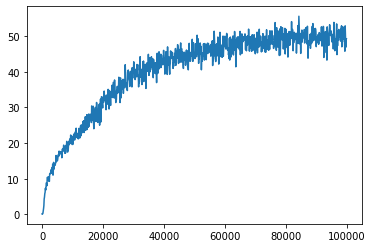

In [83]:
#file name to read
file_name = "a2c_snakenet_disc0.99"

parameters = {}
heading = ["step", "mean", "median", "min", "max", "std", "raw data"]

with open(F"data/{file_name}.csv", 'rt') as file:
    reader = csv.reader(file)
    data = [row for row in reader]
    for key,value in zip(data[1],data[2]):
        parameters[key] = value
    data_list = []
    step_list=[]
    fc_list=[]
    for items in data[5:]:
        nitems = [float(i) for i in items]
        step_list.append(nitems[0])
        fc_list.append(nitems[1])
        data_list.append(tuple(nitems[0:6])+(np.array(nitems[6:]),))
        

agent.load(F"data/{file_name}.h5")
print("Parameters:")
print(parameters)
print("\nModel:")
print(agent.model)

print("\nMean collected food:")
#Plotting
plt.plot(step_list, fc_list, label = "Mean")
plt.show()

## Visualize and Record Gameplay

In [86]:
%%time
env = SingleSnake(num_envs=1, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE)
agent.evaluate()
PATH = os.getcwd()
state = env.reset()
for episode in range(10):
    fc_sum = 0
    recorder = VideoRecorder(env, path=PATH + f'/videos/PG_{episode}.mp4')
    env.render()
    recorder.capture_frame()
    time.sleep(0.2)
    counter = 0
    while(1):
        counter+=1
        #action = agent.action(state)
        action = env.random_action()
        next_state, reward, terminal, _ = env.step(action)
        fc_sum+= (reward>0).cpu().numpy()
        env.render()
        recorder.capture_frame()
        #time.sleep(0.2)
        state = next_state
        if terminal.all() or counter==1000:
            recorder.close()
            break
    print("Completed:", terminal.any().cpu().numpy())
    print('Episode:', episode, 'Food Collected:', fc_sum)

env.close()

Completed: True
Episode: 0 Food Collected: [0]
Completed: True
Episode: 1 Food Collected: [0]
Completed: True
Episode: 2 Food Collected: [0]
Completed: True
Episode: 3 Food Collected: [0]
Completed: True
Episode: 4 Food Collected: [0]
Completed: True
Episode: 5 Food Collected: [0]
Completed: True
Episode: 6 Food Collected: [0]
Completed: True
Episode: 7 Food Collected: [0]
Completed: True
Episode: 8 Food Collected: [1]
Completed: True
Episode: 9 Food Collected: [0]
Wall time: 4.71 s


In [85]:
env.close()

## Computing Average Return

In [ ]:
test_env = SingleSnake(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)
agent.evaluate()

                       
t_state = test_env.reset()
fc_sum = torch.zeros((num_envs,)).float().to(DEFAULT_DEVICE) #foot collected

for steps in range(1000): #max steps
    t_action = agent.action(t_state)
    t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
    #anything with a positive reward is considered as food.
    fc_sum+=(t_reward>0).float()
    t_state = t_next_state
    if t_terminal.all():
        break

t_sum = fc_sum.cpu().numpy()

t_mean = np.mean(t_sum)
print("Completed:", t_terminal.sum().cpu().numpy(), "/", num_envs)
print("Mean, Median, Max, Min, std:", 
      t_mean, 
      np.median(t_sum),
      np.max(t_sum),
      np.min(t_sum),
      np.std(t_sum))